# 第9回講義 演習

In [1]:
%matplotlib inline

from __future__ import division
from collections import OrderedDict
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from theano.tensor.shared_randomstreams import RandomStreams

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
theano_rng= RandomStreams(rng.randint(1234))

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


## 課題1. Variational auto-encoder (VAE) の実装

### 1. MNISTデータセットの読み込み

In [2]:
mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist.data.astype('float32'), mnist.target.astype('int32'), random_state=1234)

mnist_X = mnist_X / 255.

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y, test_size=0.2, random_state=1234)

### 2. Layerクラスの実装

In [3]:
class Layer:
    #- Constructor
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function
        
        # Xavier
        self.W = theano.shared(rng.uniform(
                    low=-np.sqrt(6. / (in_dim + out_dim)),
                    high=np.sqrt(6. / (in_dim + out_dim)),
                    size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
    
        self.b = theano.shared(np.zeros(out_dim).astype('float32'), name='b')
        
        self.params = [self.W, self.b]
    
    #- Forward Propagation
    def f_prop(self, x):
        self.u = T.dot(x, self.W) + self.b
        self.z = self.function(self.u)
        return self.z

### 3. VAEクラスの実装
- 下界：$L({\bf \theta},{\bf \phi};{\bf x}^{(i)}) = -D_{KL}[q_{\phi}({\bf z}|{\bf x}^{(i)})||p_{\theta}({\bf z})] + \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}^{(i)}|{\bf z}^{(i,l)})$
    - KL距離：$D_{KL}[q_{\phi}({\bf z}|{\bf x}^{(i)})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j^{(i)})^2)-(\mu_j^{(i)})^2-(\sigma_j^{(i)})^2)$
    - ${\bf z}$のサンプリング：${\bf z}^{(i,l)} = {\mu}^{(i)}+{\bf \sigma}^{(i)}\odot{\bf \epsilon}^{(l)}$，${\bf \epsilon}^{(l)}\sim N(0,{\bf I})$
    - バッチについて平均をとる
    
    
- エンコーダー：$\log q({\bf z}|{\bf x}) = \log N({\bf x};{\bf \mu},{\bf \sigma}^2{\bf I})$
 
- デコーダー：$\log p({\bf x}|{\bf z}) = \sum_{i=1}^D x_i\log \hat{x}_i + (1-x_i)\log (1-\hat{x}_i)$

In [4]:
class VAE:
    #q:encoder p:decoder
    def __init__(self, q, p, random=1234):
        self.q = q
        self.p = p
        self.srng = RandomStreams(seed=random)
    
    def q_f_prop(self, x):
        # Gaussian MLP
        params = []
        layer_out = x
        for i, layer in enumerate(self.q[:-2]):
            params += layer.params
            layer_out = layer.f_prop(layer_out)
        
        params += self.q[-2].params
        mean = self.q[-2].f_prop(layer_out)
        
        params += self.q[-1].params
        var  = self.q[-1].f_prop(layer_out)
        
        return mean, var, params
    
    def p_f_prop(self, x):
        # Bernoulli MLP
        params = []
        layer_out = x
        for i, layer in enumerate(self.p):
            params += layer.params
            layer_out = layer.f_prop(layer_out)
        mean = layer_out
        
        return mean, params
    
    def lower_bound(self, x):
        # Encode
        mean, var, q_params = self.q_f_prop(x)
        KL = -0.5 * T.mean(T.sum(1 + T.log(var) - mean**2 - var, axis=1))# WRITE ME
        
        epsilon = self.srng.normal(mean.shape)# WRITE ME (HINT: use self.srng.normal [http://deeplearning.net/software/theano/library/tensor/raw_random.html])
        z = mean + T.sqrt(var) * epsilon# WRITE ME
        
        # Decode
        _x, p_params = self.p_f_prop(z)
        log_likelihood = T.mean(T.sum(x* T.log(_x) + (1 - x) * T.log(1 - _x), axis=1))# WRITE ME
        
        params = q_params + p_params
        
        lower_bound = [-KL, log_likelihood]
        
        return lower_bound, params

### 4. 更新則 ([Adam](https://arxiv.org/abs/1412.6980))

In [26]:
# https://gist.github.com/Newmu/acb738767acb4788bac3
def Adam(params, g_params, lr=0.0003, b1=0.15, b2=0.002, e=1e-7):
    updates = []
    i = theano.shared(np.float32(0.))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, g_params):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

### 5. ネットワークの定義

In [27]:
z_dim = 10

#- Gaussian MLP
q = [
    Layer(784, 500, T.nnet.relu),
    Layer(500, 400, T.nnet.relu),
    Layer(400, 350, T.nnet.relu),
    Layer(350, z_dim),                 # mean
    Layer(350, z_dim, T.nnet.softplus) # variance
]

#- Bernoulli MLP
p = [
    Layer(z_dim, 350, T.nnet.relu),
    Layer(350, 400, T.nnet.relu),
    Layer(400, 500, T.nnet.relu),
    Layer(500, 784, T.nnet.sigmoid)
]

### 6. train関数とtest関数

In [28]:
model = VAE(q, p)

x = T.fmatrix('x')
lower_bound, params = model.lower_bound(x)

g_params = T.grad(-T.sum(lower_bound), params)
updates = Adam(params, g_params)

train = theano.function(inputs=[x], outputs=lower_bound, updates=updates, allow_input_downcast=True, name='train')
test  = theano.function(inputs=[x], outputs=T.sum(lower_bound), allow_input_downcast=True, name='test')

### 7. 学習

In [30]:
batch_size = 100
n_batches = train_X.shape[0]//batch_size

for epoch in xrange(150):
    rng.shuffle(train_X)
    lowerbound_all = []
    for i in xrange(n_batches):
        start = i*batch_size
        end = start + batch_size
        lowerbound = train(train_X[start:end])
        lowerbound_all.append(lowerbound)
    
    lowerbound_all = np.mean(lowerbound_all, axis=0)
    test_lowerbound = test(test_X)
    print 'Epoch:%d, Train Lower Bound:%lf (%lf, %lf), Test Lower Bound:%lf' % (epoch, np.sum(lowerbound_all), lowerbound_all[0], lowerbound_all[1], test_lowerbound)

Epoch:0, Train Lower Bound:-97.594849 (-18.974564, -78.620285), Test Lower Bound:-99.989502
Epoch:1, Train Lower Bound:-97.497498 (-18.986368, -78.511131), Test Lower Bound:-99.797157
Epoch:2, Train Lower Bound:-97.414833 (-19.010910, -78.403923), Test Lower Bound:-99.802986
Epoch:3, Train Lower Bound:-97.277878 (-19.013340, -78.264542), Test Lower Bound:-99.763260
Epoch:4, Train Lower Bound:-97.164528 (-19.022058, -78.142471), Test Lower Bound:-99.936264
Epoch:5, Train Lower Bound:-97.115585 (-19.035385, -78.080200), Test Lower Bound:-99.946396
Epoch:6, Train Lower Bound:-97.007927 (-19.055986, -77.951942), Test Lower Bound:-99.728699
Epoch:7, Train Lower Bound:-96.941788 (-19.065561, -77.876228), Test Lower Bound:-99.799637
Epoch:8, Train Lower Bound:-96.855392 (-19.099604, -77.755791), Test Lower Bound:-99.484879
Epoch:9, Train Lower Bound:-96.740814 (-19.071529, -77.669289), Test Lower Bound:-99.622871
Epoch:10, Train Lower Bound:-96.659492 (-19.083467, -77.576027), Test Lower Boun

## 課題2. 再構成画像の可視化

### 1. Encoder

In [10]:
x = T.fmatrix('x')
mean, var, _ = model.q_f_prop(x)# WRITE ME
sample_z_function = theano.function(inputs=[x], outputs=[mean, var], allow_input_downcast=True, name='sample_z_function')

### 2. Decoder

In [11]:
z = T.fmatrix('z')
mean, _ = model.p_f_prop(z)# WRITE ME
sample_x_function = theano.function(inputs=[z], outputs=mean, allow_input_downcast=True, name='sample_x_function')

### 3. Original Image

In [12]:
def deprocess(x):
    _x = x.reshape(x.shape[0], 28, 28)
    return 1 - _x

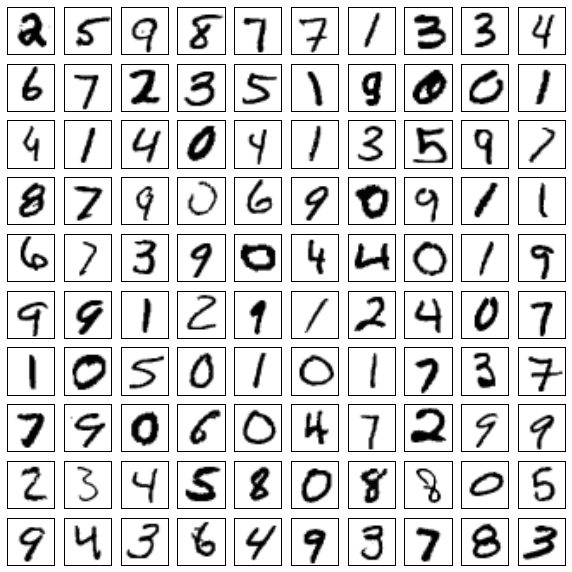

In [13]:
n_sample = 100

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(train_X[:n_sample])

for j, x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')

### 4. Reconstruction Image

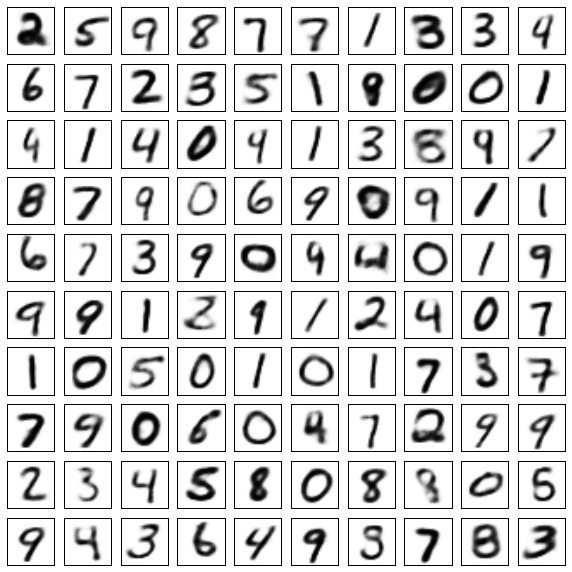

In [14]:
#- Encode
mean, var = sample_z_function(train_X[:n_sample])
sample_z = mean # Deterministic

#- Decode
sample_x = sample_x_function(sample_z)

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_x)

for j, x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')

## 課題3. 潜在変数からランダムサンプリング

- z_dimを変更したときのサンプルを比較しよう

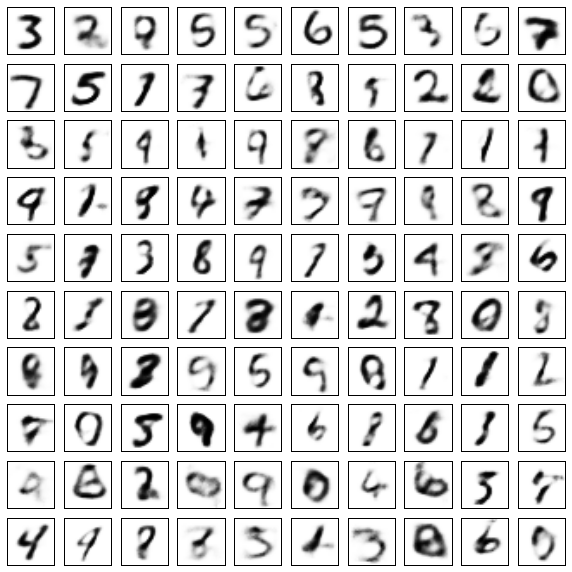

In [16]:
sample_z = np.random.standard_normal((n_sample, z_dim)).astype('float32')# WRITE ME (HINT: random sampling from a Gaussian distribution)
sample_x = sample_x_function(sample_z)# WRITE ME

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_x)

for j, x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')

## 課題4. 潜在空間の多様体の可視化

- データ間を遷移して, 潜在空間で多様体構造が学習できていることを確認しよう

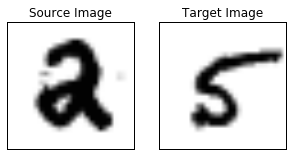

In [17]:
#- Source
x_0 = train_X[:1]

#- Target
x_1 = train_X[1:2]

fig = plt.figure(figsize=(5, 5))
ax_0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax_0.set_title('Source Image')
ax_0.imshow(deprocess(x_0)[0], 'gray')

ax_1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax_1.set_title('Target Image')
ax_1.imshow(deprocess(x_1)[0], 'gray')

plt.show()

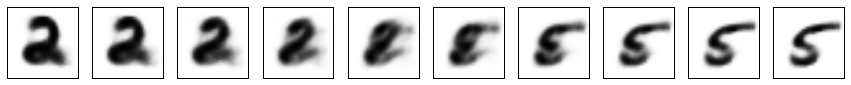

In [19]:
#- 潜在空間に写像
sample_z_0, _ = sample_z_function(x_0)
sample_z_1, _ = sample_z_function(x_1)

move = sample_z_1 - sample_z_0

fig = plt.figure(figsize=(15, 15))

for i, j in enumerate(np.linspace(0, 1, 10)):
    # 線形補間
    _z = sample_z_0 + j * move# WRITE ME
    sample_x = sample_x_function(_z)
    
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(sample_x)[0], 'gray')